# Physics 5070 Final Project

### Bejan Ghomashi and Michael Reh

## Introduction

The goal of this project was to build python modules to study quantum systems. Specifically, an eigenstate solver and time evolution module were developed in order to study phenomena such as Rabi oscillations and High Harmonic Generation. 

Rabi oscillations are of interest in many physical systems. A system with two or more bound states separated by finite energy can be made to oscillate between the states in the presence of an oscillatory driving field. An important example of this, explored in this project, is a quantum system interacting with a laser. The fundamental frequency of the oscillating electric field in a laser pulse can be tuned to the energy separating a two-level system, causing the probability of finding the system in one state or the other to oscillate in time, which we can observe via the populations of the different states. Though in this project it will be explored more as a toy model, Rabi oscillations appear in many experiments in fields such as quantum optics and quantum computing, and the model could be extended for these specific applications as needed.

High harmonic generation (HHG) is a non-linear process in which a target (e.g. atomic gas) is excited by a low frequency laser of high intensity. The emitted radiation is composed of odd harmonics of the fundamental frequency $\omega_0$. This is usually described by the "three-step model": Tunneling, free motion in the electric field, and recombination. In this project, we use a potential that mimics hydrogen, with bound states of similar energy, to produce an HHG spectrum. One major difference in this toy potential is that hydrogen supports an infinite number of bound states were as our potentials only support a few or even one (this is due to the toy potential having finite size, while true hydrogen has an infinite depth).

## Eigenstate Solver

The eigenstate solver was built based on the Numerov method for solving the time-independent Schrodinger equation (TISE). This method is stronger than Runge-Kutta methods for solving the TISE due the the absence of the first derivative in the equation. A few different implementations were tested for this project, and can be found in the module *numerov.py*. The main workhorse in this module is the *solve_TISE_numerov* method, which uses the Numerov method to solve the TISE for a given potential at a given energy. All subsequent functions are built on this method. 

To find the actual bound states, a shooting method was employed originally, with a bisection method used to search for output wavefunctions meeting an endpoint boundary condition. Because this method was found to be unstable, especially for bound states, methods involving the matching of left/right moving wavefunctions and even/odd parity states were implemented. This helped improve the stability of finding solutions for the subsequent analysis. The primary interface functions that manage the underlying calculations are the *find_bound_states* and *find_bound_states_matching* methods.

## Time Evolution

The time evolution module was developed using the Crank-Nicolson method of solving partial differential equations. This method is unitary (and so conserves probability) and unconditionally stable, so we can take any time step that is small enough to observe the physics we are interested in. The algorithm solves individual time steps as follows:

$$\psi(t+\Delta t)=e^{-iH\Delta t}\psi(t)\\
    e^{iH\Delta t/2}\psi(t+\Delta t)=e^{-iH\Delta t/2}\psi(t)\\
    (1+iH\Delta t/2)\psi(t+\Delta t)=(1-iH\Delta t/2)\psi(t)\\
    \psi(t+\Delta t)=(1+iH\Delta t/2)^{-1}(1-iH\Delta t/2)\psi(t)$$

In practice, the matrix $(1+iH\Delta t/2)$ and its inverse are banded-tridiagonal (in 1D, which is a simplification made in this project), which allows for optimizations in the matrix inversion step. In practice, three different linear solvers were tested from SciPy--the general, sparse, and banded solvers--with increases in speed in order of listing. The Crank-Nicolson solver can be found in the module *crank_nicolson.py*, with the main interface function being *do_time_evolution_mask*, and *banded_solver* performing most of the calculations.

## Rabi Oscillations

We now present a demonstration of the quantum state solver we have built. As previously stated, Rabi oscillations involve observing the state transition dynamics between two states of a quantum system. Here, we use a laser tuned to the transition between two energy levels of a double-delta function potential and observe the variation of the state populations over time.

The probability of appearing in the excited state is
$$
|c_2(t)|^2 = \frac{|\Omega|^2}{|\Omega|^2+\Delta^2}\sin^2\left(\frac{\sqrt{|\Omega|^2+\Delta^2}}{2}t\right)
$$
where $\Omega=E\langle1|x|2\rangle$ is the dipole (times the electric field), and $\Delta=\omega_2-\omega_0$ is the difference between the system energy gap $\omega_0$ and the laser energy $\omega_2$. If we are able to perfectly tune our laser such that $\omega_2\rightarrow\omega_0$,
$$
\Delta\rightarrow0\text{, and }|c_2(t)|^2\propto\sin^2\left(\frac{|\Omega|}{2}t\right)
$$
Essentially, properly tuning our laser allows us to extract the dipole of the transition between the ground and excited state. Below, we extract the dipole from the Rabi oscillations by fitting the excited state population (over time) from a system driven by an oscillating electric field. This result is compared to the exact dipole computed numerically by,
$$
\langle 1|x|2\rangle\approx \sum_i \psi_1^*(x_i)\psi_2(x_i) x_i \Delta x
$$

In [1]:
# Import necessary libraries and modules
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize

import rabi_calculation as rc
import potentials as pot

In [2]:
# Setup space grid, potential, and energy range to search for bound states
x = np.arange(-10., 10., 0.01)
V = pot.delta_potential(x, pars=[0.5, -2.0, 0.1]) + pot.delta_potential(x, pars=[-0.5, -2.0, 0.1])
Erange = np.linspace(-2.5, -0, 1000)

# Set Laser specifications
I0 = 0.001
ncyc = 200.

# Run the Rabi oscillation simulation
t, pop_ground, pop_excited, dipole = rc.rabi_calculation(x, V, Erange, I0, ncyc)

# Fit for rabi parameters somewhere in the middle where the curve is most well-defined
time_slice = np.logical_and(t>(t[-1]*0.2), t<(t[-1]*0.8))
rabi_pars, rabi_pars_cov = optimize.curve_fit((lambda x, A, dip, d : A*(np.sin(0.5*np.sqrt(I0)*dip*x + d))**2),\
                                               t[time_slice], pop_excited[time_slice], p0=[1, np.abs(dipole), 0.01])

print("Dipoles:")
print("Fit Result       = %.4f"%np.abs(rabi_pars[1]))
print("Rabi-Oscillation = %.4f"%np.abs(dipole))

Dipoles:
Fit Result       = 0.6096
Rabi-Oscillation = 0.5965


From this result, we conclude that the Rabi oscillation simulation produced an accurate calculation of this quantity. The discrepancies seen here are likely a result of the fact that our laser is finite in duration, in addition to any possible numerical errors accrued. Below, we plot the populations of the two states, demonstrating the agreement with the fit. The oscillations are nearly perfectly sinusoidal, as predicted by the theory. Note that we plot for the main duration of the laser pulse so as to avoid the laser pulse edges.

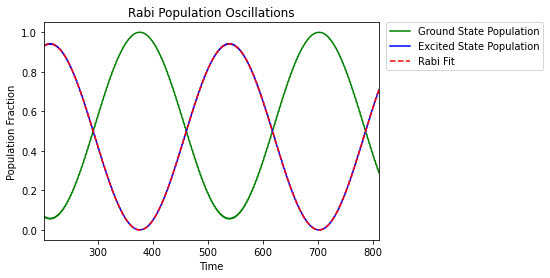

In [3]:
# Plot populations to see the oscillations
fig, ax1 = plt.subplots()
ax1.plot(t, pop_ground, 'g', label="Ground State Population")
ax1.plot(t, pop_excited, 'b', label="Excited State Population")
ax1.set_xlim(0.2*t[-1], 0.8*t[-1])
# Rabi theoretical fit
ax1.plot(t, rabi_pars[0]*np.sin(0.5*np.sqrt(I0)*rabi_pars[1]*t + rabi_pars[2])**2, 'r--', label="Rabi Fit")
ax1.legend(bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0.)
plt.ylabel("Population Fraction")
plt.xlabel("Time")
plt.title("Rabi Population Oscillations")
plt.show()

## High Harmonic Generation

Of course, the code infrastructure built in this project can do more than observe state population oscillations. Here, we simulate high harmonic generation in 1D hydrogen. Clearly, we will lack any dynamics associated with angular momentum, and our potential is finite at the origin (unlike the true $1/r$ potential), but the resulting dynamics give a good sense of the process. In the future, this work could be extended to more accurately model hydrogen or some other gas, which may be useful for any laboratory looking to explore high harmonic generation in JILA.

We start by searching for bound states in a potential that mimics the sharp $1/r$ behavior of hydrogen, but with finite depth due to numerical constraints.

In [4]:
# Import necessary libraries and modules
import numerov as nv
import laser as lz
import high_harmonics as hh

In [5]:
# Setup position and energy grids
x = np.arange(-40., 40., 0.1) 
Erange = np.linspace(-0.6, -0, 1000)

Energy -0.013866965338696281 failed to converge. Diff: 158.2659704489609
Energy -0.0027027027027027306 failed to converge. Diff: 0.1339613358305443
Energy -0.0009009009009008917 failed to converge. Diff: 3.198159917725689


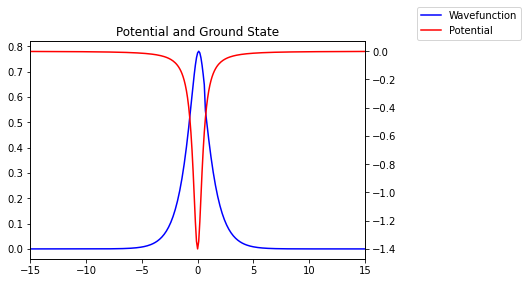

In [6]:
# Finds the ground state, then pads arrays with edge zeros to reduce edge effects
x, ground, V, energies = hh.find_expanded_groundstate(x, Vpars=[0, -2.2, 1.], Erange=Erange)

# Visualize the ground state in the potential
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(x, np.real(V), 'r', label="Potential")
ax1.plot(x, np.real(ground), 'b', label="Wavefunction")
fig.legend(bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0.)
plt.xlim(-15.,15.)
plt.title("Potential and Ground State")
plt.show()

This is a good demonstration of the numerov solver implemented in *numerov.py*. We now introduce our laser, which will be a Gaussian pulse with a frequency equal to $\omega_{\rm laser}=0.05695$ in atomic units, which is a standard choice in modern experiments exploring high harmonic generation. We then run the time evolution of the system interacting with the laser pulse and calculate the dipole response. This will be useful in calculating the corresponding dipole radiation from the dipole acceleration, which we get from Ehrenfest theorem
$$
{\rm dipole =\ } \frac{d^2}{dt^2}\langle x\rangle = \frac{1}{m}\frac{d}{dt}\langle p\rangle = -\frac{1}{m}\langle V'(x)\rangle,
$$
which is a more numerically sound method than manually taking two derivatives for finding the dipole acceleration.

In [7]:
# Run simulation to calculate quantum dipole acceleration in response to a Gaussian laser pulse
w_laser = 0.05695 # standard choice (in atomic units) for experimental laser
t, dipole_acc = hh.high_harmonic_dipoles(x, ground, V, I0=0.1, ncyc=10, w0=w_laser)

In [8]:
# Fourier transform the results to get a spectrum
w, dipole_acc_ft = hh.dirty_FT(t, dipole_acc, w0=w_laser, window=0.25)

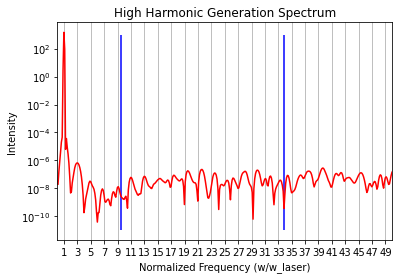

In [9]:
# Show the generated spectrum peaks
fig, ax1 = plt.subplots()
ax1.plot(w/w_laser, np.abs(dipole_acc_ft)**2, 'r-', label="Radiation Spectrum")
ax1.vlines(x=(-energies[0]/w_laser), ymin=1e-11, ymax=1e3, color='b') # Ionization potential
ax1.vlines(x=(-energies[0]/w_laser+3.17*0.025/w_laser**2), ymin=1e-11, ymax=1e3,color='b') # HHG cutoff
ax1.set_yscale("log")
ax1.set_xlim(0.,50.)
ax1.set_xticks(range(1,50,2)) # or plt.?
plt.grid(axis='x')
plt.ylabel("Intensity")
plt.xlabel("Normalized Frequency (w/w_laser)")
plt.title("High Harmonic Generation Spectrum")
plt.show()

Above we have plotted the Fourier transform of the dipole acceleration, which corresponds to the emitted ratiation spectrum of the system in response to the input laser. The frequency axis is normalized to the laser frequency ($\omega/\omega_{\rm laser}$) to emphasize that higher-order peaks are generated on the *odd* harmonics of the laser frequency (this starts to break down at the higher frequencies, but is at least visible through the first 4 harmonics). 

The first blue vertical represents the ionization potential (corresponds to the energy of the ground state). Prior to this energy, the intensity of the harmonics is exponentially suppressed, as seen in the plot. Beyond this line, the relative intensity of the successive harmonics is predicted by HHG to remain relatively constant, which we do see in our plot. There is a second cutoff energy called the HHG cutoff
$$
E = E_0+3.17\frac{I_0}{4 \omega_{laser}^2},
$$
with $E_0$ the ground state energy and $I_0$ the laser intensity. Beyond this, the relative intensity of the harmonics is predicted to once again decay exponentially. We do not see this in our plot, but of course  there are several reasons this may be the case. Aside from simple numerical error, we have been using a 1D approximation, and therefore do not account for any angular effects (e.g. angular momentum). Additionally, our potential doesn't go to $-\infty$ as $r\rightarrow0$ as is the case for real hydrogen, which may be another contributing factor (in particular, hydrogen has an infinite number of bound states, while we do not).

In any case, we do clearly see rapid intensity decay between the first and successive odd harmonics, which agrees with theoretical predictions from HHG. We also see intensity peaks on the first several odd harmonics (not even), which is another prediction from the theory. Finally, the level-off behavior of the peaks beyond the ionization potential is another theoretical prediction, and one of the main reasons HHG is of interest to experimentalists in the first place. Therefore, despite the model's limitations, this simple computational model does a good job of capturing the main characteristics of high harmonic generation. In any case, this work could be extended in the future to more accurately deal with $r\rightarrow0$ and include angular momentum in an effort to more accurately model a true atomic system, but is beyond the scope of this work.